In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler


In [207]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.224])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [208]:
train_dir = "../chest_xray/train"
test_dir = "../chest_xray/test"


In [209]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [210]:
def calculate_class_weights(dataset):
  """
  Calculates class weights based on class frequencies.

  Args:
      dataset (torch.utils.data.Dataset): Your dataset object.

  Returns:
      torch.Tensor: Class weights.
  """
  targets = torch.tensor(dataset.targets)
  
  # Count the occurrences of each class
  class_counts = torch.bincount(targets)
  
  # Calculate the total number of samples
  total_count = len(dataset)

  class_weights = 1 / (class_counts / total_count)  # Inverse class frequency
  return class_weights


In [211]:
class_weights = torch.tensor(calculate_class_weights(train_loader.dataset))
sampler = WeightedRandomSampler(class_weights, len(train_loader.dataset))


/var/folders/lf/bghrz5n10l104kzzbh5k3fg80000gn/T/ipykernel_11313/3610049353.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(calculate_class_weights(train_loader.dataset))


In [212]:
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


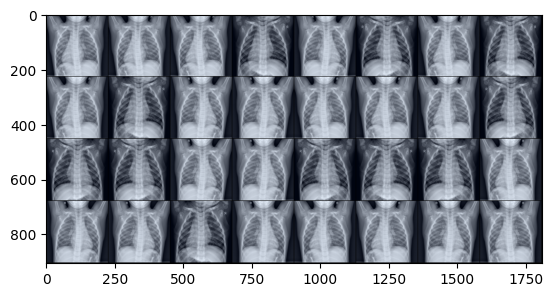

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [213]:
def imshow(img):
    img = img #/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images, normalize=True))
labels


In [214]:
print(f"Normal: {train_loader.dataset.targets.count(0)}, Pneumonia: {train_loader.dataset.targets.count(1)}")


Normal: 1341, Pneumonia: 3875


In [215]:
class PneumoniaScannerModel(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(PneumoniaScannerModel, self).__init__()
        self.base_model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

        for param in self.base_model.parameters():
            param.requires_grad = False

        num_out_ftrs = self.base_model.fc.out_features
        self.fc = torch.nn.Linear(num_out_ftrs, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x

model = PneumoniaScannerModel()


In [216]:
learning_rate = 0.001
epochs = 100


In [217]:

criterion = torch.nn.BCEWithLogitsLoss(weight=class_weights)  # Binary Cross-Entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer with learning rate


In [219]:

for epoch in range(epochs):
    for image, target in train_loader:

        target = target.float()

        output = model(image)
        print(output)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = (torch.round(output.data) == target).float().mean()
        total_loss += loss.item()
        total_acc += predictions.item()

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    print(f"Epochs: [{epoch+1}/{epochs}] | Train Loss: {avg_loss:.4f} | Trin Accuracy: {avg_acc:.4f}")


tensor([[-0.0134,  0.0545],
        [ 0.0819,  0.2683],
        [-0.0785, -0.2897],
        [-0.0134,  0.0545],
        [-0.0134,  0.0545],
        [ 0.0819,  0.2683],
        [-0.0785, -0.2897],
        [ 0.0819,  0.2683],
        [-0.0785, -0.2897],
        [-0.0240,  0.1427],
        [ 0.0819,  0.2683],
        [-0.0785, -0.2897],
        [-0.0785, -0.2897],
        [-0.0785, -0.2897],
        [-0.0240,  0.1427],
        [-0.0134,  0.0545],
        [-0.0240,  0.1427],
        [-0.0785, -0.2897],
        [-0.0785, -0.2897],
        [-0.0785, -0.2897],
        [-0.0134,  0.0545],
        [-0.0785, -0.2897],
        [-0.0785, -0.2897],
        [-0.0240,  0.1427],
        [-0.0785, -0.2897],
        [-0.0134,  0.0545],
        [-0.0134,  0.0545],
        [-0.0134,  0.0545],
        [-0.0785, -0.2897],
        [-0.0134,  0.0545],
        [-0.0134,  0.0545],
        [-0.0785, -0.2897]], grad_fn=<AddmmBackward0>)


ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 2]))